In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv("bike_marketing.csv")
df.head(3)

,company_num,google_adwords,facebook,twitter,marketing_total,revenues,employees,pop_density
0,1,65.66,47.86,52.46,166,39.26,5,High
1,2,39.10,55.20,77.40,172,38.90,7,Medium
2,3,174.81,52.01,68.01,295,49.51,11,Medium


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   company_num      172 non-null    int64  
 1   google_adwords   172 non-null    float64
 2   facebook         172 non-null    float64
 3   twitter          172 non-null    float64
 4   marketing_total  172 non-null    int64  
 5   revenues         172 non-null    float64
 6   employees        172 non-null    int64  
 7   pop_density      172 non-null    object 
dtypes: float64(4), int64(3), object(1)
memory usage: 10.9+ KB


In [3]:
df['pop_density']=df['pop_density'].astype('category')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   company_num      172 non-null    int64   
 1   google_adwords   172 non-null    float64 
 2   facebook         172 non-null    float64 
 3   twitter          172 non-null    float64 
 4   marketing_total  172 non-null    int64   
 5   revenues         172 non-null    float64 
 6   employees        172 non-null    int64   
 7   pop_density      172 non-null    category
dtypes: category(1), float64(4), int64(3)
memory usage: 9.8 KB


In [5]:
df.head(3)

,company_num,google_adwords,facebook,twitter,marketing_total,revenues,employees,pop_density
0,1,65.66,47.86,52.46,166,39.26,5,High
1,2,39.10,55.20,77.40,172,38.90,7,Medium
2,3,174.81,52.01,68.01,295,49.51,11,Medium


In [6]:
df.pop_density.unique()

['High', 'Medium', 'Low']
Categories (3, object): ['High', 'Low', 'Medium']

In [7]:
high=df.loc[df['pop_density']=='High','revenues']
medium=df.loc[df['pop_density']=='Medium', 'revenues']
low=df.loc[df['pop_density']=='Low', 'revenues']

In [9]:
import scipy.stats as stats
stats.shapiro(high)

ShapiroResult(statistic=0.9552056789398193, pvalue=0.04857487604022026)

In [10]:
stats.shapiro(medium)

ShapiroResult(statistic=0.9450081586837769, pvalue=0.017985567450523376)

In [11]:
stats.shapiro(low)

ShapiroResult(statistic=0.9840328693389893, pvalue=0.5353288650512695)

In [12]:
stats.kruskal(high, medium, low)

KruskalResult(statistic=0.900557928910252, pvalue=0.6374503008400596)

귀무가설을 기각할 수 없다. 즉 pop_density 간 모평균에 차이가 없다.

In [15]:
from patsy import dmatrices
y_train, X_train=dmatrices("revenues~google_adwords+facebook+twitter+marketing_total+employees", data=df, return_type="dataframe")

In [18]:
#warinng 무시
import warnings
warnings.filterwarnings('ignore')
# OLS 회귀를 위한 라이브러리 호출
import statsmodels.api as sm

# add_constant를 통해 상수항 생성
X_train = sm.add_constant(X_train)

# 모델 형성 및 결과 출력
model = sm.OLS(y_train, X_train).fit()
##model.summary()

In [19]:
# feature 및 target
variables = X_train.columns.tolist() 
y = y_train 

# 선택된 변수들 list 생성
forward_valriables = []

# 전진선택시 P 값을 고려할 때, 선택과 제거 임계치 설정    
sl_enter = 0.05
sl_remove = 0.05

# 각 스텝별로 선택된 변수들
sv_per_step = [] 
# 각 스텝별 수정된 결정계수
adj_r_squared_list = []
# 스텝
steps = []
step = 0


while len(variables) > 0:
    remainder = list(set(variables) - set(forward_valriables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = X_train[forward_valriables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit(disp=0)
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        forward_valriables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(forward_valriables) > 0:
            selected_X = X_train[forward_valriables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                forward_valriables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(X_train[forward_valriables])).fit(disp=0).rsquared_adj
        adj_r_squared_list.append(adj_r_squared)
        sv_per_step.append(forward_valriables.copy())
    else:
        break

In [20]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               revenues   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     279.7
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           6.96e-73
Time:                        00:03:16   Log-Likelihood:                -371.41
No. Observations:                 172   AIC:                             752.8
Df Residuals:                     167   BIC:                             768.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         28.3427      0.600     47.

In [21]:
fitted=model.predict()
residual=df['revenues']-fitted

- 정규성

In [22]:
import scipy.stats
sr=scipy.stats.zscore(residual)
(x, y), _=scipy.stats.probplot(sr)

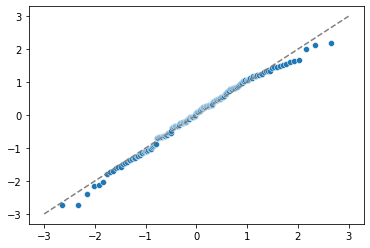

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x,y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

In [26]:
scipy.stats.shapiro(residual)

ShapiroResult(statistic=0.9887027144432068, pvalue=0.18587186932563782)

귀무가설을 기각할 수 없다. 즉 정규성을 따른다.

- 잔차의 등분산성

<AxesSubplot:ylabel='revenues'>

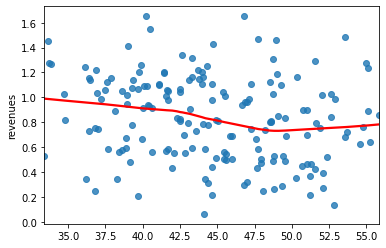

In [27]:
import numpy as np
sns.regplot(fitted, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color':'red'})

- 잔차의 독립성

In [28]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(model.resid)

2.0987268231478464

2에 가까운 값이므로 독립성을 만족한다고 해석할 수 있다.